## Logistic Regression sampling

In [1]:
using Pkg
Pkg.activate("../.")

using Random 
using Turing, TuringGLM
using StatsModels
using StatsPlots
using DataFrames
# We need a logistic function, which is provided by StatsFuns.
using StatsFuns: logistic
using Optim 
using LinearAlgebra: I

# set seed 
rng = MersenneTwister(616);

  Activating project at `~/Gibbs-sampling/FRAN`


In [2]:
p = 10      # Number of features 
n = 2000    # Number of points

2000

Generate synthetic data and run simple Logistic Regression. The first covariate is the only one with influence in the binary outcome.

In [3]:
X = rand(rng, Normal(), (n,p))
Y = [rand(rng, Bernoulli(logistic(2*X[i,1]))) for i in 1:n];

We define our probabilistic model. Notice that `DynamicPPL.Model <: AbstractMCMC.AbstractModel`.

In [4]:
@model function logistic_regression(x, y, n, p, σ)

    # Prior distribution
    slopes ~ MvNormal(zeros(p), σ^2 * I)

    for i in 1:n
        prob = logistic(sum(slopes .* x[i,:]))
        y[i] ~ Bernoulli(prob)
    end
end

model = logistic_regression(X, Y, n, p, 1.0);

We do a Hamiltionian MC sampler because this tend to be more accurate and a naive Metropolis-Hashting `MH()` gives weird posterior. 

In [5]:
chain = sample(model, HMC(0.1, 5), 10_000)
# chain = sample(model, MH(), 10_000)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:36


Chains MCMC chain (10000×20×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 45.66 seconds
Compute duration  = 45.66 seconds
parameters        = slopes[1], slopes[2], slopes[3], slopes[4], slopes[5], slopes[6], slopes[7], slopes[8], slopes[9], slopes[10]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

   slopes[1]    1.9867    0.1166    0.0148    40.5701   118.8843    1.0396     ⋯
   slopes[2]    0.0670    0.0556    0.0027   401.2991   466.1383    1.0002     ⋯
   slopes[3]   -0.0642    0.0623    0.0029   403.9811   537.5545    1.0154     ⋯
   slopes[4]    0.0577    0.0626    0.0031   360.0182   513.5807    1.0031     ⋯
   s

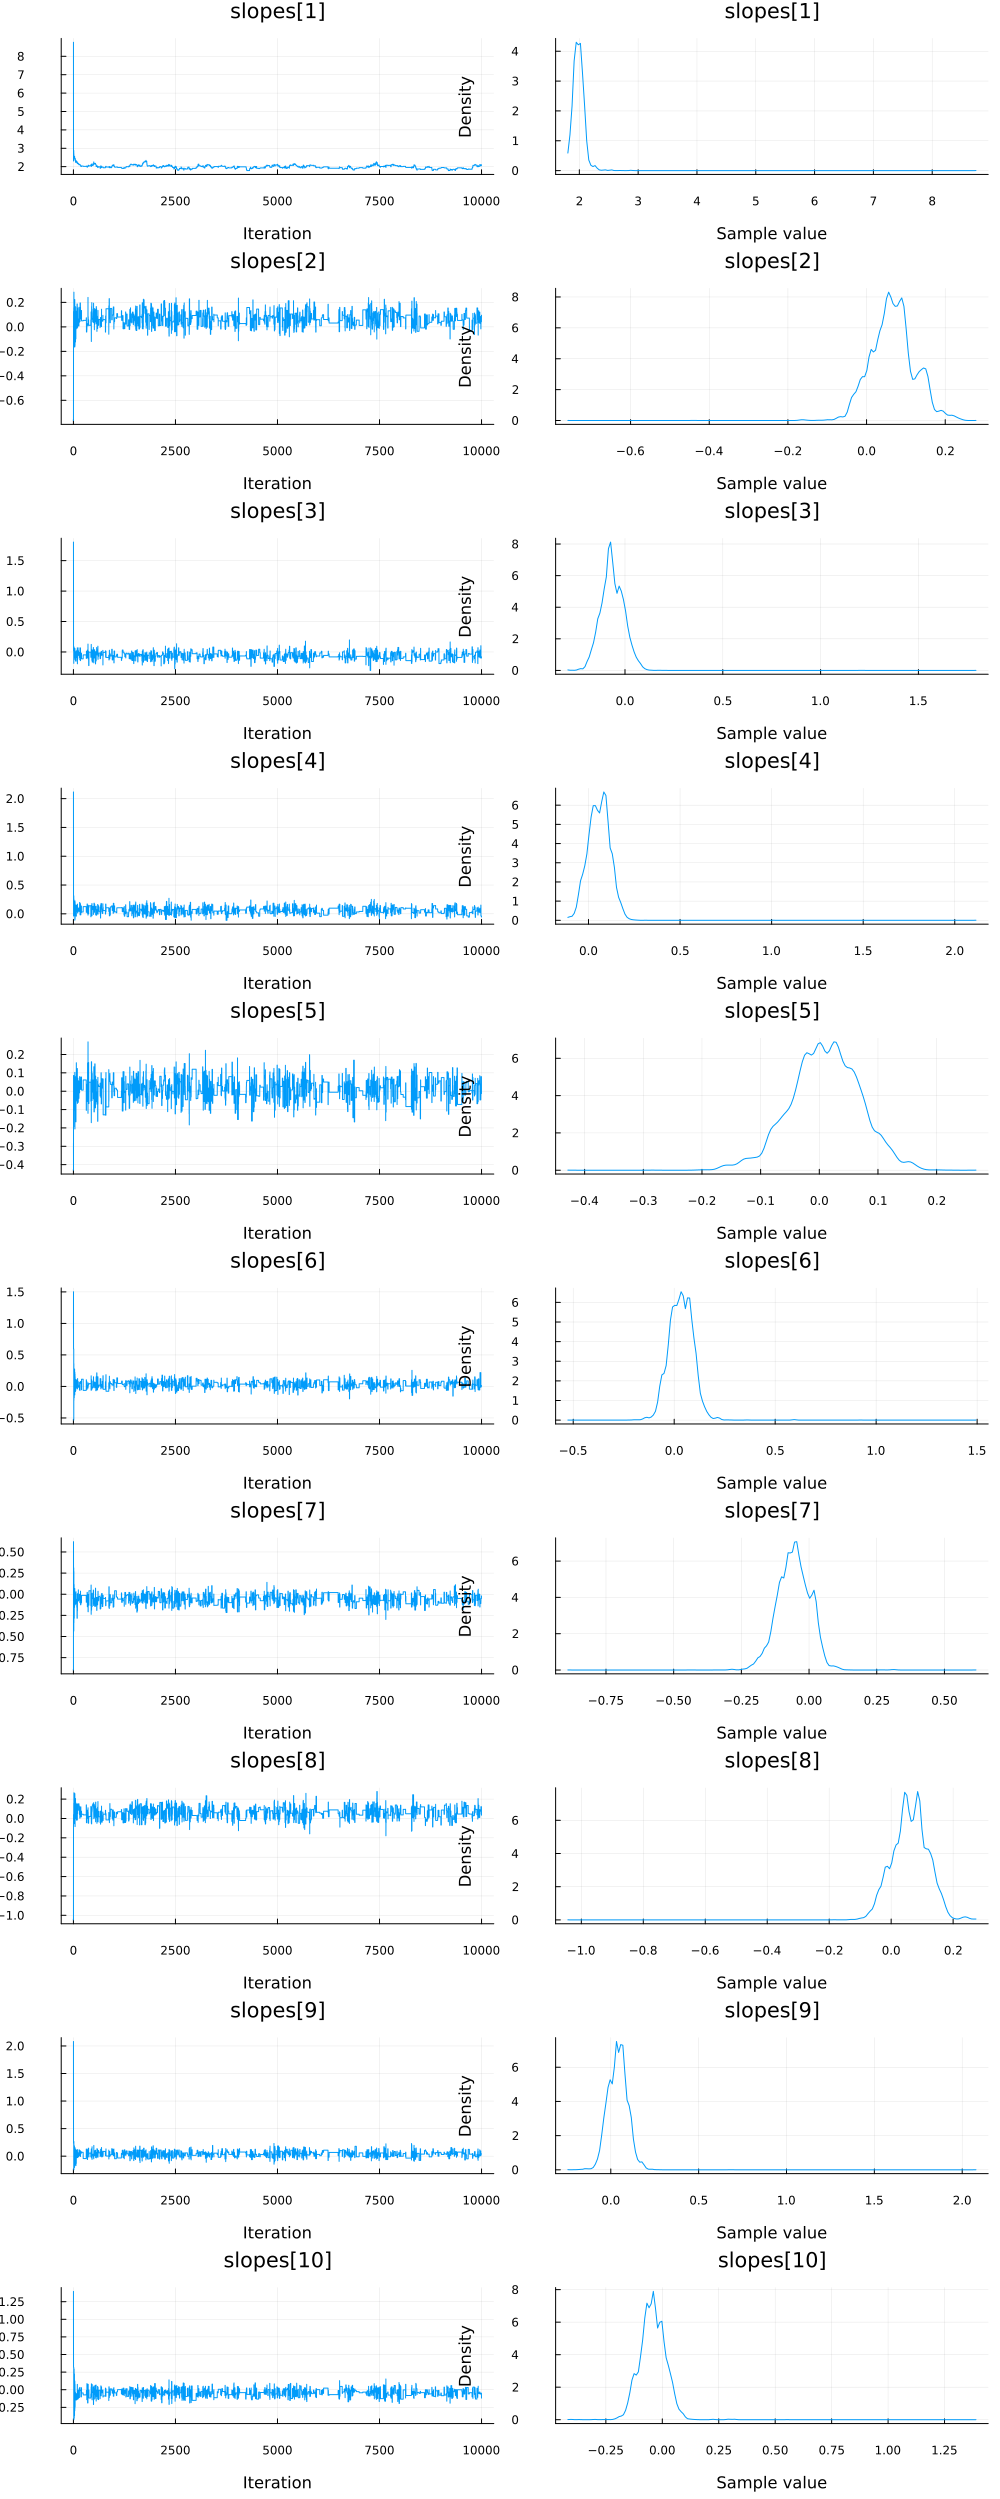

In [6]:
plot(chain)

We can also estimate the MLE associated to such model and see that we obtain the same solition. 

In [7]:
optimize(model, MLE())

ModeResult with maximized lp of -936.77
[1.9534844701740375, 0.06717914672568313, -0.060903161241417536, 0.05691235218446073, 0.011809291467672631, 0.03606350189047379, -0.05421291770965816, 0.0572004228911564, 0.0412303716189396, -0.0378196180938842]

## Customized logistic sampler

The script `LogisticSampler.jl` includes an implementation of the customized sampling procedure where we add a sample of the forward model in the response updates to approximate the right posterior. 

In [8]:
include("../src/sample/LogisticSampler.jl")

log_likelihood (generic function with 1 method)

In [9]:
θ₀ = zeros(p)
spl_logistic = LogisticSampler(θ₀)

chain = Chains(sample(model, spl_logistic, 10_000))

Initializing iterator...


Sampling: 100%|█████████████████████████████████████████| Time: 0:00:17


Chains MCMC chain (10000×10×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
parameters        = param_1, param_2, param_3, param_4, param_5, param_6, param_7, param_8, param_9, param_10

Summary Statistics
  parameters      mean       std      mcse     ess_bulk     ess_tail      rhat ⋯
      Symbol   Float64   Float64   Float64      Float64      Float64   Float64 ⋯

     param_1    1.9396    0.0898    0.0009    9805.0564    9303.0848    1.0000 ⋯
     param_2    0.0667    0.0570    0.0006   10120.3523    9620.1954    0.9999 ⋯
     param_3   -0.0594    0.0571    0.0006   10077.7096    9638.7380    0.9999 ⋯
     param_4    0.0563    0.0580    0.0006   10009.0697    9787.5213    1.0004 ⋯
     param_5    0.0111    0.0581    0.0006   10049.8653    9797.7915    0.9999 ⋯
     param_6    0.0357    0.0573    0.0006   10261.7235   10045.4418    1.0002 ⋯
     param_7   -0.0526    0.0572    0.0006    9516.7207    9970.7914    0.9999 ⋯
     param_

In [ ]:
plot(chain)

In [87]:
fieldnames(typeof(model.args))

(:x, :y, :n, :p, :σ)